In [1]:
import os
import numpy as np
np.set_printoptions(precision=1)
import nibabel as nib
import json
import matplotlib.image as mpimg
from os.path import join as opj
import matplotlib.pyplot as plt
from glob import glob as glb
import nipype.interfaces.fsl as fsl # importing FSL interface functions
from nilearn.plotting import plot_anat, plot_epi, view_img, plot_roi
from nipype import Node, MapNode, Workflow, JoinNode  # components to construct workflow
from bids.layout import BIDSLayout  # BIDSLayout object to specify file(s)
from nilearn.image import mean_img, resample_img, resample_to_img
from nilearn.plotting import plot_stat_map
os.environ[ "ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS" ] = "48"

In [2]:
%matplotlib inline
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FEAT, FEATModel, FLIRT, FNIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold, Merge, ApplyWarp, MeanImage, Level1Design)
from nipype.interfaces.afni import Refit, Volreg, SkullStrip, Allineate, Deconvolve
from nipype.interfaces.ants import RegistrationSynQuick, Registration, ApplyTransforms, N4BiasFieldCorrection
from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect

In [3]:
from nipype.interfaces.base import CommandLine, InputMultiPath, File
from nipype.interfaces.afni.base import AFNICommandInputSpec, AFNICommandOutputSpec, AFNICommand

#Since original interface for AFNI 3dMean was limited to 2 inputs, 
#I decided to create my own simple class that can handle a list of files as an input
class Mean3dInputSpec(AFNICommandInputSpec):
    in_files = InputMultiPath(
        File(desc="input file to 3dMean", exists=True),
        argstr="%s",
        position=-1,
        mandatory=True,
        copyfile=False,
    )
    out_file = File(
        name_template="%s_mean",
        desc="output image file name",
        argstr="-prefix %s",
        name_source="in_files")
    
class Mean3d(AFNICommand):
    _cmd = '3dMean'
    input_spec = Mean3dInputSpec
    output_spec =AFNICommandOutputSpec

In [4]:
def get_affine(path_to_file):
    return nib.load(path_to_file).affine
def get_voxel_dim(path_to_file):
    return nib.load(path_to_file).header.get_zooms()
def get_shape(path_to_file):
    return nib.load(path_to_file).shape

In [5]:
def getBL(mean_epi, num_prestim_slices):
    file = nib.load(mean_epi)
    bl = nib.Nifti1Image(np.mean(file.dataobj[:, :, :, :num_prestim_slices],axis=-1), \
                         file.affine, file.header)
    path = opj(output_dir,'lvl_1@mean', 'BL.nii.gz')
    nib.save(bl, path)
    return path

In [6]:
def getStim(stim_duration):
    stim_beg_path = opj(mouse_dir, 'stim_beg.txt')
    f = open(stim_beg_path, "w")
    f.write(f'{stim_duration}')
    f.close()
    return stim_beg_path

In [7]:
# Directory where your data set resides.

hipp_labels_path = '/data/data/mr/atlas/scaled/hipp_labels_downsamp.nii.gz'
cort_labels_path = '/data/data/mr/atlas/scaled/cort_labels_downsamp.nii.gz'
bslg_labels_path = '/data/data/mr/atlas/scaled/bslg_labels_downsamp.nii.gz'
dien_labels_path = '/data/data/mr/atlas/scaled/dien_labels_downsamp.nii.gz'

atlas_path = '/data/data/mr/atlas/scaled/template_downsamp.nii.gz'

mouse_dir = '/data/data/mr/testDS/mouse_20210304/'

bids_dir = opj(mouse_dir,'bids')

output_dir = opj(mouse_dir, 'output')

working_dir = 'working_dir'

stim_beg = getStim(40)

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/numpy/ma/core.py:2795: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)


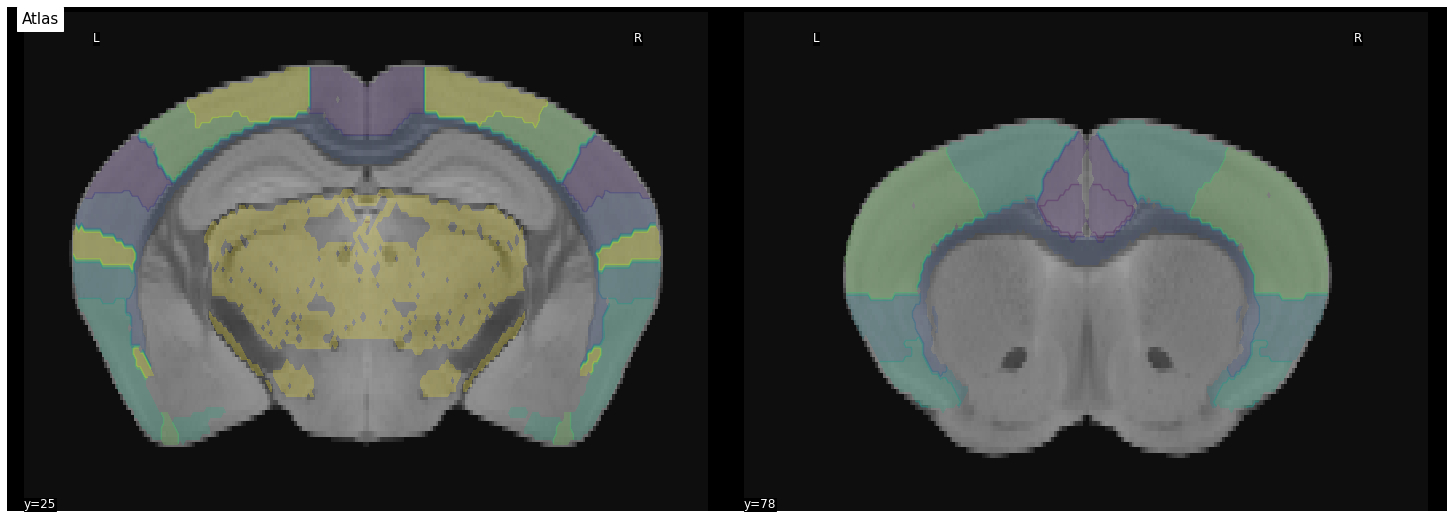

In [8]:
fig = plt.figure(figsize=(20,7))
display = plot_anat(atlas_path, display_mode='y', cut_coords=[25, 78], figure=fig, title="Atlas")
display.add_contours(dien_labels_path, levels=np.linspace(1,np.max(nib.load(atlas_path).dataobj),7), filled=True, alpha=0.25)
display.add_contours(cort_labels_path, levels=np.linspace(1,np.max(nib.load(cort_labels_path).dataobj),7), filled=True, alpha=0.25)

In [9]:
# Create Directory where the data set resides.
import shutil

if os.path.exists(output_dir):
    try:
        shutil.rmtree(output_dir)
    except OSError as e:
        print("Error: %s : %s" % (output_dir, e.strerror))
else:
    os.mkdir(output_dir)

In [10]:
# Creating the layout object for this BIDS data set
layout = BIDSLayout(bids_dir)

subjects = layout.get_subjects()
acquisitions = layout.get_acquisitions()
tasks = layout.get_tasks()
sessions = layout.get_sessions()
runs = layout.get_runs()
print(f"subjects - {subjects}, \nsessions - {sessions},\nacquisitions - {acquisitions}, \ntasks - {tasks}, \nruns - {runs}")

subjects - ['0001'], 
sessions - ['FDWS'],
acquisitions - ['FLASH', 'EPI'], 
tasks - ['4L', '25L', '25R', '4R'], 
runs - [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


In [11]:
#Assigning filenames and JSON randon file for TR
if acquisitions[0] == 'EPI':
    EPI_files = layout.get(subject=subjects, acquisition=acquisitions[0], extensions=['nii.gz'], return_type='file')
    FLASH_files = layout.get(subject=subjects, acquisition=acquisitions[1], extensions=['nii.gz'], return_type='file')
else:
    FLASH_files = layout.get(subject=subjects, acquisition=acquisitions[0], extensions=['nii.gz'], return_type='file')
    EPI_files = layout.get(subject=subjects, acquisition=acquisitions[1], extensions=['nii.gz'], return_type='file')
print(f'Number of functional images: {len(EPI_files)} \nNumber of anatomical images: {len(FLASH_files)}')

Number of functional images: 36 
Number of anatomical images: 1


In [12]:
#subjects = ['0001_1']

In [13]:
# Data iterator
# Infosource - a function free node to iterate over the list of subject names
#------------------------------------------FUNC------------------------------------------
infosource_func = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource_func")
infosource_func.iterables = [('subject_id', subjects), ('task_name', tasks)]

func_file = opj('sub-{subject_id}', f'ses-{sessions[0]}', 'func', 'sub-{subject_id}_ses-FDWS_task-{task_name}_acq-EPI_run-*_bold.nii.gz')

templates_func = {'func': func_file}
#------------------------------------------ANAT------------------------------------------
infosource_anat = Node(IdentityInterface(fields=['subject_id']),
                  name="infosource_anat")
infosource_anat.iterables = [('subject_id', subjects)]

anat_file = opj('sub-{subject_id}', f'ses-{sessions[0]}', 'anat','sub-{subject_id}_ses-FDWS_acq-FLASH_T1w.nii.gz')

templates_anat = {'anat': anat_file}




selectfiles_anat = Node(SelectFiles(templates_anat, 
                               base_directory=bids_dir), name="selectfiles_anat")
selectfiles_func = Node(SelectFiles(templates_func, 
                               base_directory=bids_dir), name="selectfiles_func")

In [14]:
scale = 20
TR=1.0
#----------------------------------MEAN_FUNC------------------------------------------
mean_scale = Node(Refit(in_file = EPI_files[0],
                       deoblique = True,
                       xyzscale = scale),
                  name='mean_scale')

mean_motion_corr = Node(Volreg(num_threads=48,
                               outputtype='NIFTI_GZ'),
                        name='mean_motion_corr')

func_mean_brain_extraction = Node(BET(output_type='NIFTI_GZ',
                                      mask = True),
                 name='func_mean_brain_extraction')

func_brain_mask_extraction = Node(BET(output_type='NIFTI_GZ', 
                                      mask = True),
                 name='func_brain_mask_extraction')

func_mean2anat_L = Node(FLIRT(  # target: FLASH - weighted
                       dof=6,
                       #cost = 'normmi', # normizied mutual info
                       #interp ='spline',
                       output_type='NIFTI_GZ'), 
                 name="func2anat_L")

func_mean2anat_applywarp = Node(ApplyWarp(),
                               name='func_mean2anat_applywarp')
#---------------------------------------FUNC------------------------------------------

epi_scale = MapNode(Refit(#in_file = EPI_files[0],
                       deoblique = True,
                       xyzscale = scale),
                  name='epi_scale', iterfield=['in_file'])

epi_motion_corr = MapNode(Volreg(num_threads=48,
                               outputtype='NIFTI_GZ'),
                        name='epi_motion_corr', iterfield=['in_file'])

extract = MapNode(ExtractROI(t_min=0, 
                          t_size=-1, 
                          output_type='NIFTI_GZ'),
                 name="extract", iterfield=['in_file'])

slicetimer = MapNode(SliceTimer(index_dir=False,
                             interleaved=True,
                             time_repetition=TR),
                 name="slicetimer", iterfield=['in_file'])

func2anat_applywarp = MapNode(ApplyWarp(),
                               name='func2anat_applywarp', iterfield=['in_file'])

func2atlas_applywarp = MapNode(ApplyWarp(),
                               name='func2atlas_applywarp', iterfield=['in_file'])

epi_mean = Node(Mean3d(outputtype='NIFTI_GZ'),
                  name='epi_mean')

deconv = Node(Deconvolve(#outputtype='NIFTI_GZ', 
                         stim_times = [(1, stim_beg, 'BLOCK(20,1)')], 
                         stim_label = [(1,'stim_1')], 
                         tout = True),
             name='deconv')
#---------------------------------------ANAT------------------------------------------
scaler_anat = Node(Refit(deoblique=True,
                         xyzscale=scale),
                 name = 'scaler_anat')

anat_N4bias = Node(N4BiasFieldCorrection(
                        dimension=3,
                        bspline_fitting_distance=25,
                        save_bias=True,
                        num_threads = 12,
                        #shrink_factor=4,
                        n_iterations=[200, 200, 200, 200],
                        convergence_threshold=1e-11),
                    name='N4bias_correction')

anat_brain_extraction = Node(BET(output_type='NIFTI_GZ',
                                  mask = True),
                 name='anat_brain_extraction')

anat2atlas_L = Node(FLIRT(  # target: FLASH - weighted
                       dof=12,
                       cost = 'normmi', # normizied mutual info
                       interp ='spline',
                       reference = atlas_path,
                       output_type='NIFTI_GZ'), 
                 name="anat2atlas_L")


datasink = Node(DataSink(base_directory=output_dir),
               name='datasink')

In [15]:
mean_wf = Workflow(name='mean_wf', base_dir=opj(output_dir, working_dir))

In [16]:
#anat_N4bias.help()

In [17]:
mean_wf.connect([
                    #-----------------------------------MEAN_FUNC-----------------------------------------
                    ( mean_scale, mean_motion_corr,                          [('out_file','in_file')]),
                    ( mean_motion_corr, func_mean_brain_extraction,           [('out_file','in_file')]),
    
                    #------------------------------------FUNC_MEAN2ANAT-----------------------------------
                    ( func_mean_brain_extraction, func_mean2anat_L,           [('out_file','in_file')]),
                    ( anat_brain_extraction, func_mean2anat_L,                [('out_file','reference')]),
                    ( func_mean2anat_L, func_mean2anat_applywarp,             [('out_file','in_file')]),
                    ( anat2atlas_L, func_mean2anat_applywarp,                 [('out_matrix_file','premat')]),
                    ( anat2atlas_L, func_mean2anat_applywarp,                 [('out_file','ref_file')]),
                    ( func_mean2anat_applywarp, func_brain_mask_extraction,   [('out_file','in_file')]),
                    
    
                    #---------------------------------------ANAT------------------------------------------
                    ( infosource_anat, selectfiles_anat,                   [('subject_id','subject_id')]),
                    ( selectfiles_anat, scaler_anat,                       [('anat','in_file')]),
                    ( scaler_anat, anat_N4bias,                            [('out_file','input_image')]),
                    ( anat_N4bias, anat_brain_extraction,                  [('output_image','in_file')]),
                    #------------------------------------ANAT2ATLAS---------------------------------------
                    ( anat_brain_extraction, anat2atlas_L,                 [('out_file','in_file')]),
                    
    
    
                    #---------------------------------------FUNC------------------------------------------
                    ( infosource_func, selectfiles_func,       [('subject_id','subject_id'),('task_name','task_name')]),
                    ( selectfiles_func, epi_scale,             [('func','in_file')]),
                    ( epi_scale, extract,                      [('out_file','in_file')]),
                    ( extract, slicetimer,                     [('roi_file','in_file')]),
                    ( slicetimer, epi_motion_corr,             [('slice_time_corrected_file','in_file')]),
                    ( mean_motion_corr, epi_motion_corr,       [('out_file','basefile')]),
                    #------------------------------------FUNC2ANAT----------------------------------------
                    ( epi_motion_corr, func2anat_applywarp,             [('out_file','in_file')]),
                    ( anat_brain_extraction, func2anat_applywarp,       [('out_file','ref_file')]),
                    ( func_mean2anat_L, func2anat_applywarp,            [('out_matrix_file','premat')]),
                    
                    #------------------------------------FUNC2ATLAS----------------------------------------
                    ( func2anat_applywarp, func2atlas_applywarp,         [('out_file','in_file')]),
                    ( anat2atlas_L, func2atlas_applywarp,                [('out_file','ref_file')]),
                    ( anat2atlas_L, func2atlas_applywarp,                [('out_matrix_file','premat')]),
                    ( func2atlas_applywarp, epi_mean,                    [('out_file','in_files')]),
                    ( epi_mean, deconv,                                  [('out_file','in_files')]),
                    ( func_brain_mask_extraction, deconv,                [('mask_file','mask')]),
    
                    #--------------------------------------DATASINK-----------------------------------------
                    ( mean_motion_corr, datasink,             [('out_file',         'mean_func.@mean_motion_corr')]),
                    #( epi_motion_corr,  datasink,              [('out_file','func.@epi_motion_corr')]),
                    ( func_mean_brain_extraction, datasink,   [('out_file',         'mean_func.@mean_brain')]),
                    ( func_brain_mask_extraction, datasink,   [('mask_file',        'mean_func.@')]),
                    ( anat_brain_extraction, datasink,        [('out_file',         'anat.@brain')]),
                    ( anat_brain_extraction, datasink,        [('mask_file',        'anat.@mask')]),
                    ( anat2atlas_L, datasink,                 [('out_matrix_file',  'anat2atlas_L.@anat2atlas_affine_mtrx')]),
                    ( anat2atlas_L, datasink,                 [('out_file',         'anat2atlas_L.@anat2atlas')]),
                    ( func_mean2anat_L, datasink,             [('out_file',         'mean_func2anat.@mean_func2anat')]),
                    ( func_mean2anat_L, datasink,             [('out_matrix_file',  'mean_func2anat.@mean2anat_affine_mtrx')]),
                    ( func_mean2anat_applywarp, datasink,     [('out_file',         'mean_func2atlas.@mean2atlas')]),
                    ( anat2atlas_L, datasink,                 [('out_matrix_file',  'mean_func2atlas.@anat2atlas_affine_mtrx')]),
                    ( func2anat_applywarp, datasink,          [('out_file',         'func2anat.@')]),
                    ( func2atlas_applywarp, datasink,         [('out_file',        'func2atlas.@')]),
                    ( epi_mean, datasink,                     [('out_file',         'lvl_1@mean')]),
                    ( deconv, datasink,                       [('out_file',         'lvl_1@out')]),
                    ( deconv, datasink,                       [('reml_script',      'lvl_1@reml')]),
                    ( deconv, datasink,                       [('x1D',              'lvl_1@x1D')]),
                    ( deconv, datasink,                       [('cbucket',          'lvl_1@cbucket')]),
                ])

In [18]:
## Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-'),
                 #('_run_', 'run-'),
                 ('_task_name_', '_task-'),
                 ('_func2atlas_applywarp', ''),
                 ('_fwhm_', 'fwhm-'),
                 ('_roi', ''),
                 ('_mcf', ''),
                 ('_st', ''),
                 ('_flirt', ''),
                 ('_volreg',''),
                 ('.nii.gz_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ('_warp',''),
                ]
#_subject_id_0000004_task_name_25W'
#subjFolders = [('fwhm-%s/' % f, 'fwhm-%s_' % f) for f in smooth_kernel]
#substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

In [19]:
# Visualize the detailed graph
from IPython.display import Image
#mean_wf.write_graph(graph2use='flat', format='png', simple_form=True)
#Image(filename=opj(mean_wf.base_dir, 'mean_wf', 'graph_detailed.png'))

210308-06:13:41,89 nipype.workflow INFO:
	 Generated workflow graph: /data/data/mr/testDS/mouse_20210304/output/working_dir/mean_wf/graph.png (graph2use=colored, simple_form=True).


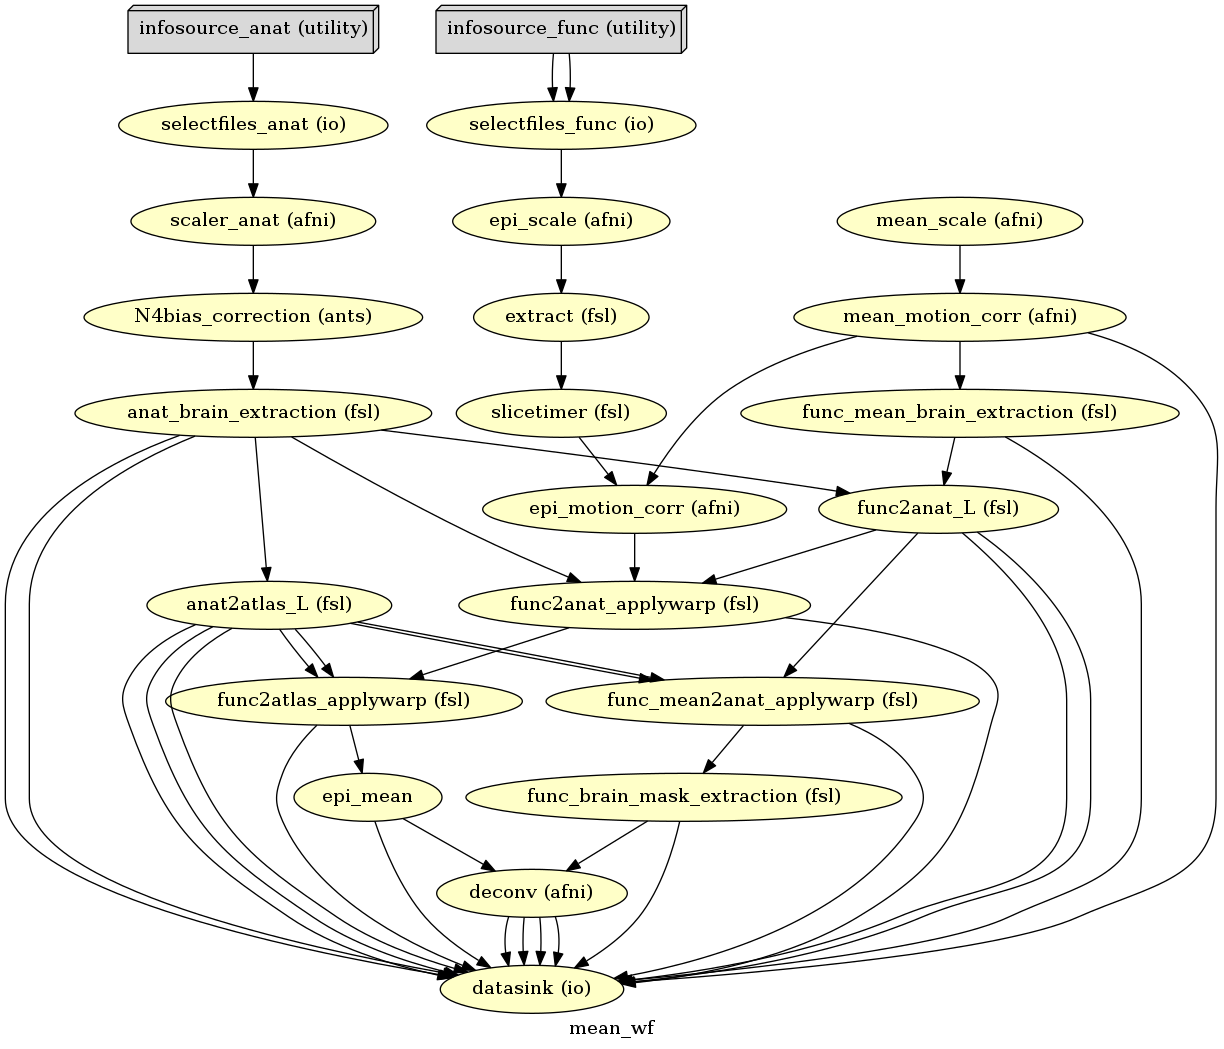

In [20]:
# Create preproc output graph
mean_wf.write_graph(graph2use='colored', format='png', simple_form=True)


Image(filename=opj(mean_wf.base_dir, 'mean_wf', 'graph.png'))

In [21]:
mean_wf.run('MultiProc', plugin_args={'n_procs': 70})

210308-06:13:41,431 nipype.workflow INFO:
	 Workflow mean_wf settings: ['check', 'execution', 'logging', 'monitoring']
210308-06:13:41,478 nipype.workflow INFO:
	 Running in parallel.
210308-06:13:41,484 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 338.91/338.91, Free processors: 70/70.
210308-06:13:41,581 nipype.workflow INFO:
	 [Node] Setting-up "mean_wf.selectfiles_func" in "/data/data/mr/testDS/mouse_20210304/output/working_dir/mean_wf/_subject_id_0001_task_name_25R/selectfiles_func".210308-06:13:41,581 nipype.workflow INFO:
	 [Node] Setting-up "mean_wf.selectfiles_func" in "/data/data/mr/testDS/mouse_20210304/output/working_dir/mean_wf/_subject_id_0001_task_name_25L/selectfiles_func".210308-06:13:41,582 nipype.workflow INFO:
	 [Node] Setting-up "mean_wf.selectfiles_func" in "/data/data/mr/testDS/mouse_20210304/output/working_dir/mean_wf/_subject_id_0001_task_name_4L/selectfiles_func".


210308-06:13:41,583 nipype.workflow INFO:
	 [Node] 

In [22]:
#os.listdir(opj(output_dir,'lvl_1@out','sub-0001_1'))

# Check processed file existance for:
## allignment to anatomy

In [23]:
func2anat_path = glb(opj(output_dir,'func2anat', f'sub-{subjects[0]}', 
                                   f'sub-{subjects[0]}_task-{tasks[0]}',
                                    '_func2anat_applywarp*','*_bold.nii.gz'))[0]

mean_func2anat_path = glb(opj(output_dir,'mean_func2anat',
                                   f'sub-{subjects[0]}',
                                    '*_bold_brain.nii.gz'))[0]

anat_brain_path = glb(opj(output_dir,'anat',
                              f'sub-{subjects[0]}',
                               '*FLASH_T1w_corrected_brain.nii.gz'))[0]

anat_mask_path = glb(opj(output_dir,'anat',
                              f'sub-{subjects[0]}',
                               '*FLASH_T1w_corrected_brain_mask.nii.gz'))[0]

print([os.path.exists(item) for item in (func2anat_path, mean_func2anat_path, anat_brain_path, anat_mask_path)])

[True, True, True, True]


## allignment to atlas

In [24]:
anat2atlas_path = opj(output_dir,'anat2atlas_L', 
                                f'sub-{subjects[0]}',         
                                f'sub-{subjects[0]}_ses-{sessions[0]}_acq-FLASH_T1w_corrected_brain.nii.gz')

mean_func2atlas_path = glb(opj(output_dir,'lvl_1@mean',
                               f'sub-{subjects[0]}',
                                f'sub-{subjects[0]}_task-{tasks[0]}', 
                                '*.nii.gz'))[0]

mean_func2atlas_mask_path = glb(opj(output_dir,'mean_func',
                                              f'sub-{subjects[0]}',
                                               '*_mask.nii.gz'))[0]

mean_func2atlas_brain_path = glb(opj(output_dir,'mean_func2atlas',
                                               f'sub-{subjects[0]}',
                                                '*_bold_brain.nii.gz'))[0]

print([os.path.exists(item) for item in (anat2atlas_path, mean_func2atlas_path, mean_func2atlas_mask_path, mean_func2atlas_brain_path)])

[True, True, True, True]


## deconvolved data for each of conditions (stimulations)

In [25]:
deconvolved_epi_path = {}
for task in tasks:
    deconvolved_epi_path[task] = opj(output_dir,'lvl_1@out',
                                                 f'sub-{subjects[0]}',
                                               f'sub-{subjects[0]}_task-{task}',
                                               'Decon.nii')
    
print([os.path.exists(item) for item in list(deconvolved_epi_path.values())])

[True, True, True, True]


## atlases and labels

In [44]:
label = (hipp_labels_path, cort_labels_path, bslg_labels_path, dien_labels_path)
label_name = ('hipp_labels_path', 'cort_labels_path', 'bslg_labels_path', 'dien_labels_path')

In [26]:
description = ['4 [Hz] left whisker', '25 [Hz] left whisker', '25 [Hz] right whisker', '4 [Hz] right whisker']
conditions = list(zip(tasks, description))

In [27]:
a = 0
out_file = nib.load(deconvolved_epi_path[tasks[a]])
corr = nib.Nifti1Image(out_file.dataobj[:,:,:,:,2], out_file.affine, out_file.header)

In [42]:
slices_1 = [5, 15, 25]
slices_2 = [35, 45, 55]
threshold = 3.
dim=-0.3

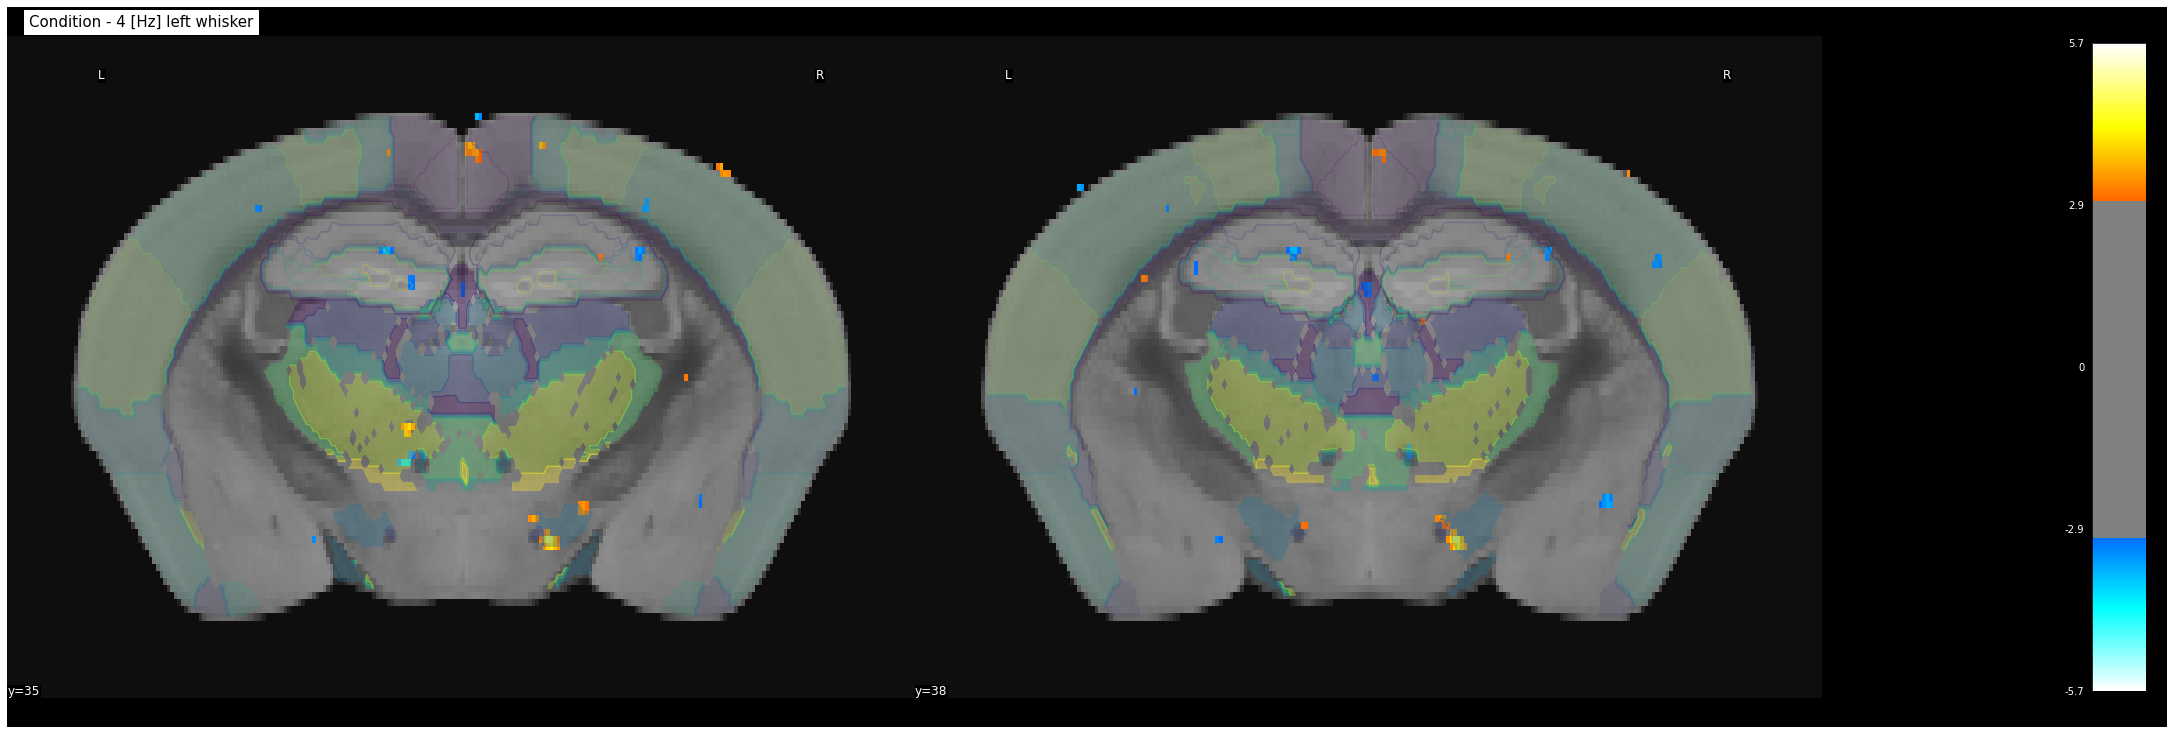

In [65]:
from nilearn.plotting import plot_stat_map
fig = plt.figure(figsize=(30,10))
d = plot_stat_map(corr, bg_img=atlas_path, display_mode='y', 
              threshold=threshold, cut_coords=[35,38], figure=fig, title = f"Condition - {conditions[a][1]}")
d.add_contours(cort_labels_path, filled=True, alpha=0.15)
d.add_contours(hipp_labels_path, filled=False, alpha=0.25)
d.add_contours(dien_labels_path, filled=True, alpha=0.35)

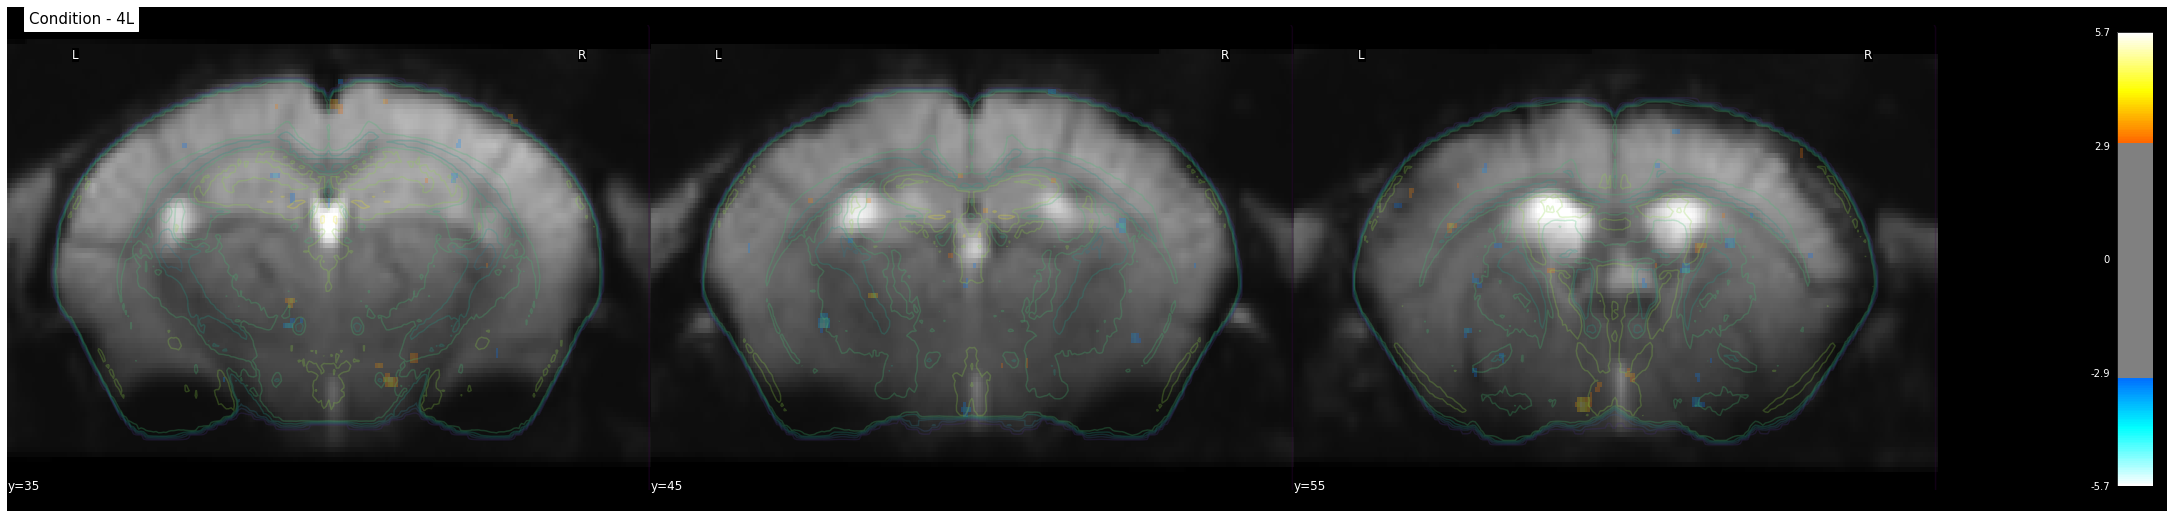

In [64]:
fig = plt.figure(figsize=(30,7))
d = plot_stat_map(corr, bg_img=mean_img(mean_func2atlas_path), display_mode='y', 
              threshold=threshold, cut_coords=slices_2, figure=fig,  dim=dim, alpha=0.25, title=f"Condition - {tasks[a]}")
d.add_contours(atlas_path, filled=False, alpha=0.25)

In [32]:
b = 3
print(tasks[b],conditions[b][1])
out_file = nib.load(deconvolved_epi_path[tasks[b]])
corr_25 = nib.Nifti1Image(out_file.dataobj[:,:,:,:,2], out_file.affine, out_file.header)

4R 4 [Hz] right whisker


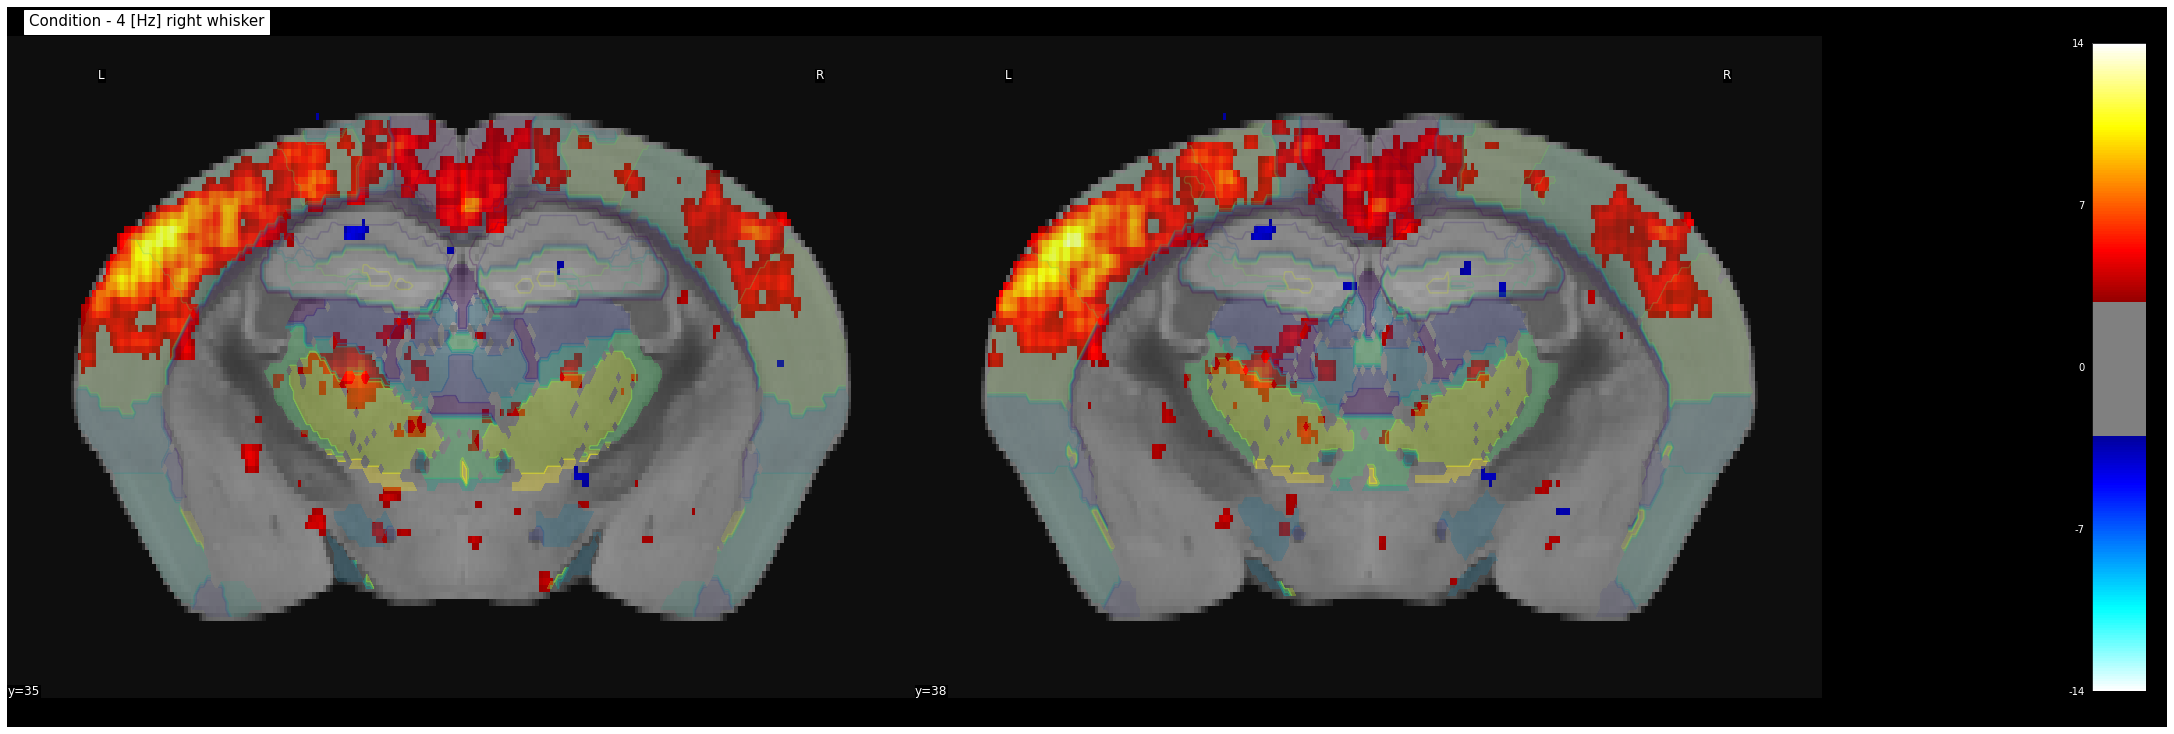

In [55]:
from nilearn.plotting import plot_stat_map
fig = plt.figure(figsize=(30,10))
d = plot_stat_map(corr_25, bg_img=atlas_path, display_mode='y', 
              threshold=threshold, cut_coords=[35,38], figure=fig, title = f"Condition - {conditions[b][1]}")
d.add_contours(cort_labels_path, filled=True, alpha=0.15)
d.add_contours(hipp_labels_path, filled=False, alpha=0.25)
d.add_contours(dien_labels_path, filled=True, alpha=0.35)

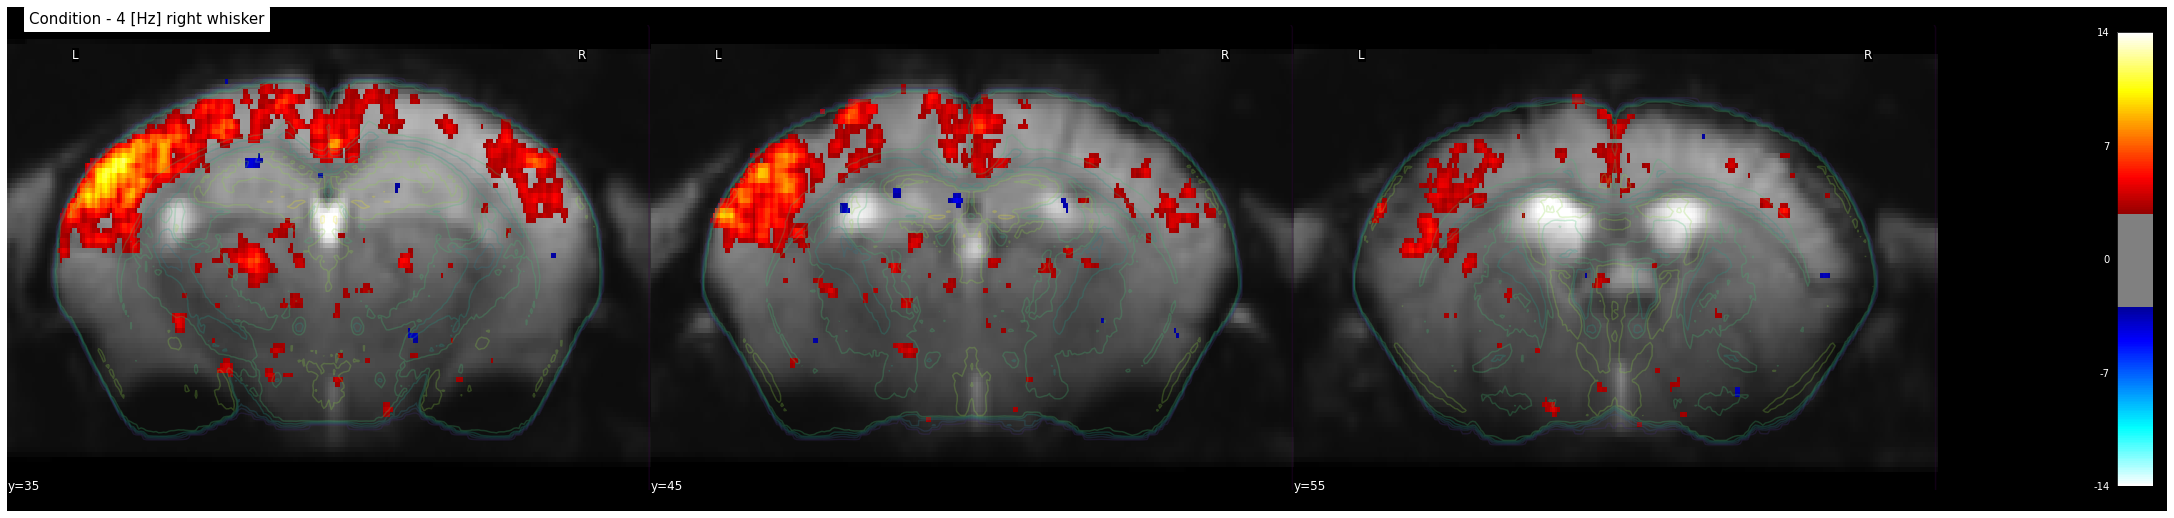

In [45]:
from nilearn.plotting import plot_stat_map
fig = plt.figure(figsize=(30,7))
d = plot_stat_map(corr_25, bg_img=mean_img(mean_func2atlas_path), display_mode='y', 
              threshold=threshold, cut_coords=slices_2, figure=fig,   dim=dim, title = f"Condition - {conditions[b][1]}")
d.add_contours(atlas_path, filled=False, alpha=0.25)

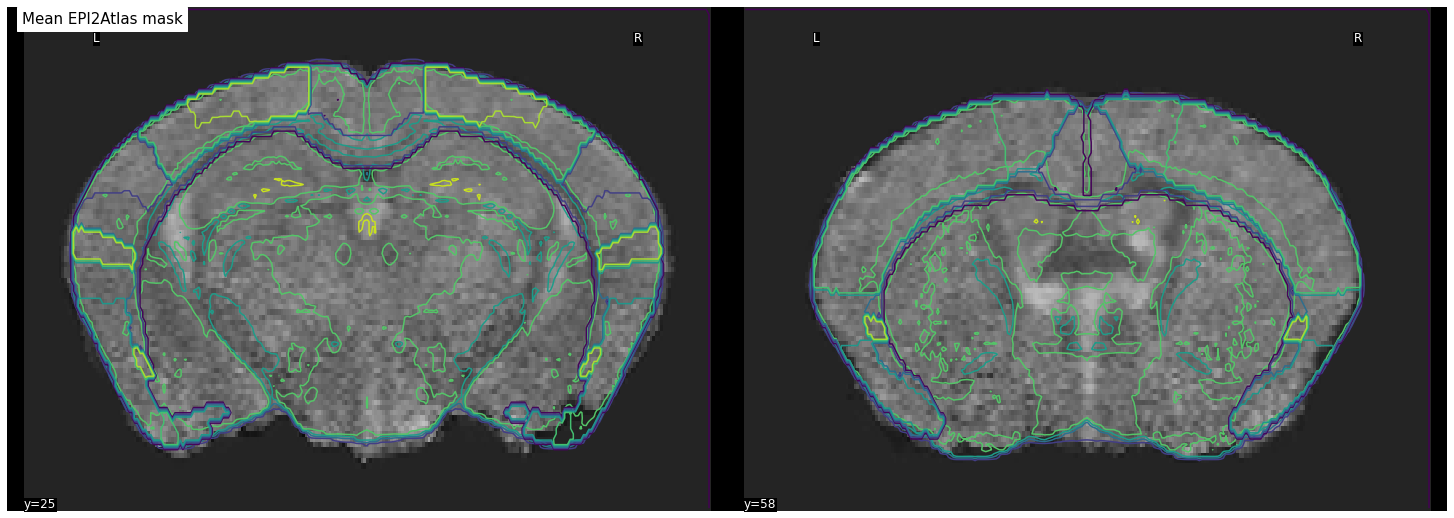

In [57]:
fig = plt.figure(figsize=(20,7))
display = plot_anat(anat2atlas_path, display_mode='y', cut_coords=[25, 58], figure=fig, dim=dim, title="Mean EPI2Atlas mask")
display.add_contours(atlas_path, levels=np.linspace(1,np.max(nib.load(atlas_path).dataobj),7))
display.add_contours(cort_labels_path, levels=np.linspace(1,np.max(nib.load(cort_labels_path).dataobj),7))
#display.add_contours(a2a_path, levels=np.linspace(1,np.max(nib.load(a2a_path).dataobj),7))
#display.add_contours(mf2atlas_path,levels=np.linspace(1,np.max(nib.load(mf2a_path).dataobj),17), alpha=0.7, filled=True)
#display.add_contours(labels_path, filled=True, alpha=0.25)
display.annotate('H')

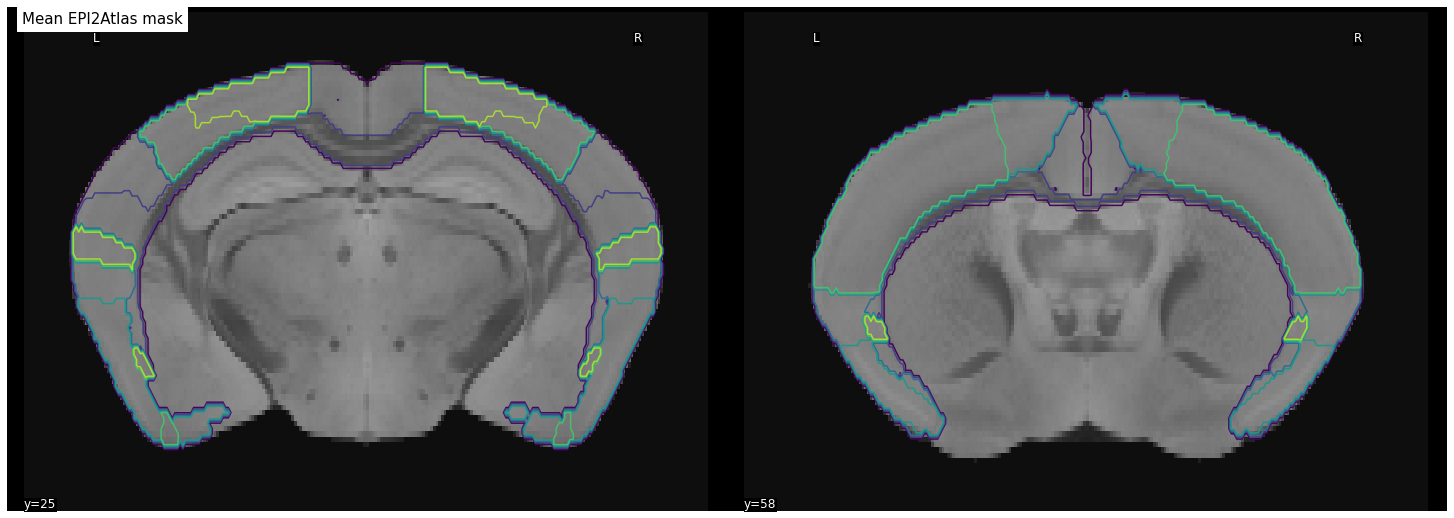

In [62]:
fig = plt.figure(figsize=(20,7))
display = plot_anat(atlas_path, display_mode='y', cut_coords=[25, 58], figure=fig,title="Mean EPI2Atlas mask")
#display.add_contours(atlas_path, levels=np.linspace(1,np.max(nib.load(atlas_path).dataobj),7))
display.add_contours(cort_labels_path, levels=np.linspace(1,np.max(nib.load(cort_labels_path).dataobj),7))
#display.add_contours(a2a_path, levels=np.linspace(1,np.max(nib.load(a2a_path).dataobj),7))
#display.add_contours(mf2atlas_path,levels=np.linspace(1,np.max(nib.load(mf2a_path).dataobj),17), alpha=0.7, filled=True)
#display.add_contours(labels_path, filled=True, alpha=0.25)
display.annotate('H')

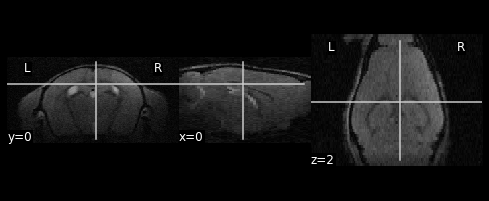

In [59]:
plot_anat(mean_img(FLASH_files[0])

In [ ]:
mean_scale = Node(Refit(in_file = res.merged_file,
                       deoblique = True,
                       xyzscale = scale),
                  name='mean_scale')

In [ ]:
mean_res = mean_scale.run()

In [ ]:
fig = plt.figure(figsize=(20,10))
plot_anat(mean_img(mean_res.outputs.out_file), figure=fig)


In [ ]:
mean_motion_corr = Node(Volreg(in_file = mean_res.outputs.out_file, num_threads=48,
                               outputtype='NIFTI_GZ'),
                        name='mean_motion_corr')

In [ ]:
mmc_res = mean_motion_corr.run()

In [ ]:
path = opj('/data/data/mr/testDS/', 'merged.nii.gz')
path

In [ ]:
nib.save(mean_img(mmc_res.outputs.out_file), path)

In [ ]:
os.path.exists(path)

In [ ]:
func_N4bias = Node(N4BiasFieldCorrection( input_image = mean_func2anat_path,
                        dimension=3,
                        bspline_fitting_distance=100,
                        save_bias=True,
                        num_threads = 12,
                        shrink_factor=2,
                        n_iterations=[200, 200, 200, 200],
                        convergence_threshold=1e-11),
                    name='N4bias_correction')

In [ ]:
res = func_N4bias.run()

In [ ]:
fig = plt.figure(figsize=(20,5))
plot_anat(res.outputs.output_image, display_mode='z', cut_coords=slices_2, figure=fig)

In [ ]:
fig = plt.figure(figsize=(20,5))
plot_anat(mean_img(mmc_res.outputs.out_file), display_mode='y', cut_coords=[-12,0, 10], figure=fig)